# High performance computing in Python

In this tutorial you will learn how to use different Python libraries, compatible with Numpy, to reduce the computational time for multidimensional array operation. You will also check how to use a tiling strategy to manage raster datasets that does not fit in memory. At the end, you will combine these approaches in a processing workflow highly optimized for a single tile (chunk of raster data), but also able to process multiple tiles in parallel using available the CPU cores.

Additionally to Numpy, the follow libraries/modules will be used during the tutorial:
* [Bootleneck](https://bottleneck.readthedocs.io/en/latest/): Collection of Numpy fast functions written in C, which are able to manage NaN values,
* [NumExpr](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/index.html): Numeric expression evaluator memory optimized,
* [Numba](http://numba.pydata.org/): Just-in-time Python compiler able to translate user defined numerical algorithms in C or FORTRAN,
* [eumap.parallel](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.parallel.utils.html#module-eumap.parallel.utils): eumap implementation for multi-core parallelization strategies, written purely in Python.

First, let's import some common python modules and libraries

In [1]:
from pathlib import Path
import numpy as np

from eumap.misc import find_files
from eumap.raster import read_rasters, save_rasters
from eumap import plotter 

... and setup our ``raster_dir``:

In [2]:
ODSE_DATA_DIR = Path.home().joinpath('ODSE_workdir').joinpath('data')
TILE_ID = 5606 # The other tile_id available is 14580

raster_dir = ODSE_DATA_DIR.joinpath(f'tile_{TILE_ID}')

print(f'ODSE data dir: {ODSE_DATA_DIR}')
print(f'Raster dir: {raster_dir}')

ODSE data dir: /home/opengeohub/ODSE_workdir/data
Raster dir: /home/opengeohub/ODSE_workdir/data/tile_5606


## Array Reduction

First, you will optimize a array reduction over the Landsat data, one of the [temporal datasets](01_introduction_to_odse_datasets) produced by ODSE. For the scope of this tutorial, an array reduction is primarily a [Numpy operation]() over one or more dimensions of a multidimensional array, producing an output with less data than the input.

Here is a book example to calculate the maximum value over a 2D array:

In [3]:
in_data = np.array([[1,2], [3,1]])
out_data = np.max(in_data, axis=0)

print(f'input_shape={in_data.shape} output_shape={out_data.shape}')
print(f'result= {out_data}')

input_shape=(2, 2) output_shape=(2,)
result= [3 2]


Now it's time to work with real data. Let's read the Landsat rasters, specifically the red band and percentile 50. 

Be aware with the ``dtype`` and ``size`` of the loaded array

In [4]:
def _info(data):
    return f' shape={data.shape} dtype={data.dtype} size={(data.nbytes / 1024 / 1024):.2f} MB'

raster_files = find_files(raster_dir, '*red*landsat*p50*.tif')
red_data, _ = read_rasters(raster_files=raster_files, dtype="float32")
print(_info(red_data))

 shape=(1000, 1000, 84) dtype=float32 size=320.43 MB


The standard way of implement an array reduction is using the [statistics functions](https://numpy.org/doc/stable/reference/routines.statistics.html) available in Numpy. In the context of the Earth Observation data it is better to use ``nan*`` functions, which ignore the nodata (``np.nan``) during the calculation. This specific dataset (tile ``5606``) were prepared by [ODSE](https://opendatascience.eu/) so that the cloud and cloud shadow pixels were removed and all nodata pixels over the [land mask](https://gitlab.com/geoharmonizer_inea/spatial-layers#the-land-mask) were gapfilled. Although these raster layers have a nodata values only over the ocean water (the tile ``14580`` has no nodata at all), that's not the case for the most part of publicly available satellite images.

To evaluate the performance between the different libraries, let's use the [timeit magic cell](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit), provided by [ipython](https://ipython.readthedocs.io), with five repetitions and producing a time estimate based in the average and standard deviation of the individual executions.

In [5]:
time_np =  %timeit -r 5 -o np.nanmedian(red_data, axis=(2))

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


6.25 s ± 53.7 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


Now let's evaluate the performance of [Bottleneck](https://bottleneck.readthedocs.io/en/latest/) executing the same operation:

In [6]:
import bottleneck as bn
time_bn = %timeit -r 5 -o bn.nanmedian(red_data, axis=(2))

1.1 s ± 3.54 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


This is a **remarkable improvement**! Imagine this performance difference over 7000x more data, what is actually almost the number of [tiles](https://gitlab.com/geoharmonizer_inea/spatial-layers#standard-tiling-system) necessary to cover the Continental Europe.

However, it's important to check if the data produced by the two libraries is exactly the same using the [array_equal](https://numpy.org/doc/stable/reference/generated/numpy.array_equal.html) function.

In [7]:
red_med_bn = bn.nanmedian(red_data, axis=(2))
red_med_np = np.nanmedian(red_data, axis=(2))

print(f'(red_med_np == red_med_bn) = {np.array_equal(red_med_np, red_med_bn, equal_nan=True)}')

(red_med_np == red_med_bn) = True


Numba is a [more complex library](https://numba.readthedocs.io/en/stable/user/index.html), which allows different possibilities of optimizations. Here we will be restrict to the basic usage of a [``@jit decorator``](https://numba.readthedocs.io/en/stable/user/jit.html#signature-specifications) in ``nopython`` mode and with automatic parallelization. Nevertheless, Numba doesn't support [the ``axis`` argument for nanmedian](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html), used to reduce the time dimension in Numpy and [Bottleneck](https://bottleneck.readthedocs.io/en/latest/). You can solve it by reshaping the input array into two dimensions.

In [8]:
last_dim = red_data.shape[-1]
print(f'Numpy/Bottleneck input shape: {red_data.shape}')
print(f'Numba input shape: {red_data.reshape(-1,last_dim).shape}')

Numpy/Bottleneck input shape: (1000, 1000, 84)
Numba input shape: (1000000, 84)


After that, you are ready to check the performance of [Numba](https://numba.readthedocs.io/en/stable/user/index.html):

In [9]:
from numba import prange, jit

last_dim = red_data.shape[-1]
out_shape = red_data.shape[:-1]

@jit(parallel=True)
def _reduce(data):
    
    x = np.zeros(len(data))
    for i in prange(data.shape[0]):
        x[i] = np.nanmedian(data[i])
    
    return x

time_nb = %timeit -r 5 -o _reduce(red_data.reshape(-1,last_dim)).reshape(out_shape)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


418 ms ± 55.8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


Don't forget to check the output consistency:

In [10]:
red_med_nb = _reduce(red_data.reshape(-1,last_dim)).reshape(out_shape)
print(f'(red_med_np == red_med_nb) = {np.array_equal(red_med_np, red_med_nb, equal_nan=True)}')

(red_med_np == red_med_nb) = True


You can also check the data using [eumap.plotter](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.plotter.html)

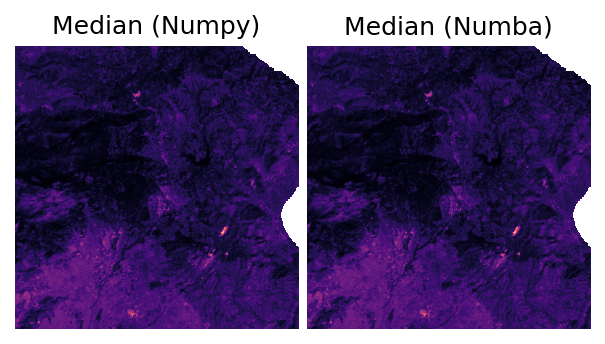

In [11]:
plotter.plot_rasters(red_med_np, red_med_nb, cmaps="magma", figsize=5, titles=['Median (Numpy)', 'Median (Numba)'])

Now that you have all results, you can create a summary table using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html):

In [12]:
import pandas as pd
timeit_res = pd.DataFrame({
    'library':[ 'Numpy', 'Bootleneck', 'Numba' ], 
    'average':[ time_np.average, time_bn.average, time_nb.average ], 
    'std':[ time_np.stdev, time_bn.stdev, time_nb.stdev ], 
}).sort_values(by='average', ascending=True)

timeit_res

,library,average,std
2,Numba,0.418452,0.055796
1,Bootleneck,1.095522,0.003535
0,Numpy,6.249609,0.053724


## Numeric Operation

As second example, you will optimize a numeric operation over the same data (Landsat), however this time using the red and NIR band to derive a [spectral index](usgs.gov/core-science-systems/nli/landsat/landsat-surface-reflectance-derived-spectral-indices?qt-science_support_page_related_con=0#qt-science_support_page_related_con). You will perform a mathematical operation over two multidimensional arrays, deriving as result a third array with the same dimensions.

Here it is a book example for a multiplication of two 2D arrays:

In [13]:
in_data1 = np.array([[4,4], [4,4]])
in_data2 = np.array([[3,3], [3,3]])

out_data = in_data1 * in_data2

print(f'input1_shape={in_data1.shape} input2_shape={in_data2.shape} output_shape={out_data.shape}')
print('Result:')
print(out_data)

input1_shape=(2, 2) input2_shape=(2, 2) output_shape=(2, 2)
Result:
[[12 12]
 [12 12]]


Seeking to reduce the size of the data in memory, let's load just the first 10 years (first 40 images):

In [14]:
red_files_all = find_files(raster_dir,  '*red*landsat.glad.ard_p50*.tif')
nir_files_all = find_files(raster_dir,  '*nir*landsat.glad.ard_p50*.tif')

red_data, red_files = read_rasters(raster_files=red_files_all[0:40], dtype="float32")
nir_data, nir_files = read_rasters(raster_files=nir_files_all[0:40], dtype="float32")

print(_info(red_data))
print(_info(nir_data))

 shape=(1000, 1000, 40) dtype=float32 size=152.59 MB
 shape=(1000, 1000, 40) dtype=float32 size=152.59 MB


Using this two bands you will calculate the [Normalized Difference Vegetation Index (NDVI)](https://eos.com/make-an-analysis/ndvi/), which is a common index for Earth Observation data that strongly correlates with the photosynthetic activity of vegetation:

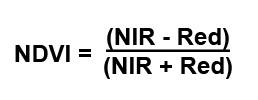

The NDVI calculation in Numpy is straightforward:

In [15]:
def _ndvi(red, nir):
    return (nir - red)/(nir + red)

time_ndvi_np = %timeit -r 5 -o _ndvi(red_data, nir_data)

249 ms ± 2.54 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


For Numba you can use the [``@vectorize`` decorator](https://numba.pydata.org/numba-doc/latest/user/vectorize.html), which implements the traditional [NumPy ufuncs](https://numpy.org/doc/stable/reference/ufuncs.html) in C, thus improving the executing performance:

In [16]:
from numba import vectorize, float32

@vectorize([float32(float32, float32)], nopython=True)
def _ndvi_nb(red, nir):
    return (nir - red)/(nir + red)

time_ndvi_nb = %timeit -r 5 -o _ndvi_nb(red_data, nir_data)

111 ms ± 582 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


If you compare the both result it should be exactly the same:

In [17]:
ndvi_np = _ndvi(red_data, nir_data)
ndvi_nb = _ndvi_nb(red_data, nir_data)

print(f'(ndvi_np == ndvi_nb) = {np.array_equal(ndvi_np, ndvi_nb, equal_nan=True)}')

(ndvi_np == ndvi_nb) = True


As expected, Numba performs better than Numpy, although at this time you will include a new library in the competition. [Numpexpr](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/index.html) runs over a virtual machine based on the iterator [``nditer``](https://numpy.org/doc/stable/reference/arrays.nditer.html), introduced in NumPy 1.6, which improves the memory usage for numeric operations and optimize the broadcasting and conversion related to multidimensional arrays.

The usage of Numexpr occurs through the [``evaluate``](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/user_guide.html#usage-notes) method, which supports [several functions/operations](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/user_guide.html#supported-functions):

In [18]:
import numexpr as ne

expression = '(nir - red) / (nir + red)'
params = { 'nir': nir_data, 'red': red_data }

time_ndvi_ne = %timeit -r 5 -o ne.evaluate(expression, params, optimization='aggressive')

83.2 ms ± 1.04 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


Don't forget to check the consistency of the output:

In [19]:
ndvi_ne = ne.evaluate(expression, params)
print(f'(ndvi_np == ndvi_ne) = {np.array_equal(ndvi_np, ndvi_ne, equal_nan=True)}')

(ndvi_np == ndvi_ne) = True


Time to produce the performance summary:

In [20]:
import pandas as pd
timeit_res = pd.DataFrame({
    'library':[ 'Numpy', 'Numexpr', 'Numba' ], 
    'average':[ time_ndvi_np.average, time_ndvi_ne.average, time_ndvi_nb.average ], 
    'std':[ time_ndvi_np.stdev, time_ndvi_ne.stdev, time_ndvi_nb.stdev ], 
}).sort_values(by='average', ascending=True)

timeit_res

,library,average,std
1,Numexpr,0.083186,0.001038
2,Numba,0.111370,0.000582
0,Numpy,0.248586,0.002538


Considering that you produced 40 NDVI images, you can use the follow function to visualize the result per year:

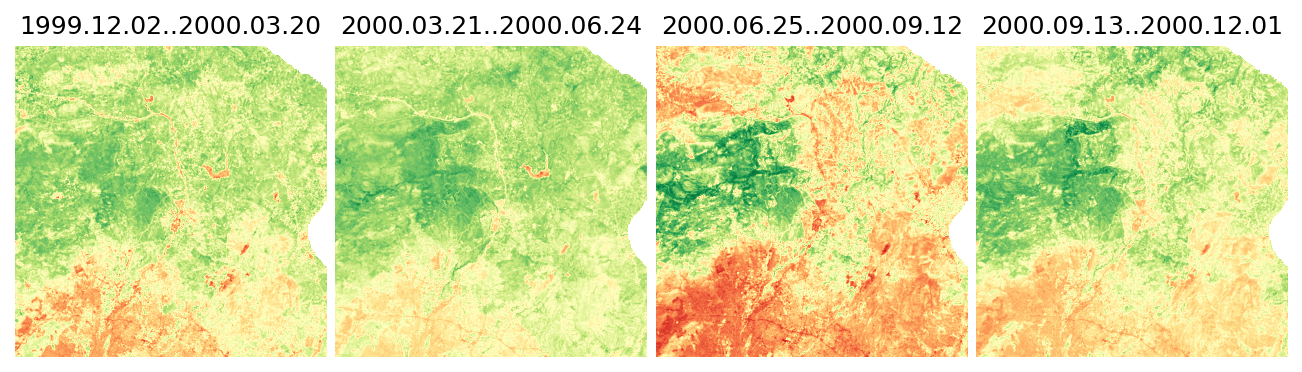

In [23]:
def plot_ts(data, raster_files, year, dt_position = 6):
    data_arr, title_arr = [], []
    
    for i in range(0, len(raster_files)):
        raster_dt = raster_files[i].stem.split('_')[dt_position]
        raster_year = raster_dt.split('..')[1].split('.')[0]
        
        if raster_year == str(year):
            data_arr.append(data[:,:,i])
            title_arr.append(raster_dt)
    
    plotter.plot_rasters(*data_arr, cmaps="RdYlGn", figsize=11, titles=title_arr)
    
plot_ts(ndvi_nb, red_files, '2000')

Why not can save the NDVI images as GeoTIFF using [eumap.raster module](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.raster.save_rasters.html#eumap.raster.save_rasters), keeping the filename standard, and visualize them in [QGIS](https://www.qgis.org/en/site/):

In [24]:
ndvi_files = [ Path(str(f)
                    .replace('_nir_', '_ndvi_')
                    .replace('tile_14580', 'tile_14580_ndvi')) 
              for f in nir_files
]

ndvi_files = save_rasters(nir_files[0], ndvi_files, ndvi_nb, dtype='float32', verbose=True)

[21:22:32] Writing 40 raster files using 4 workers


## Tiling processing

Now that you figured out the fastest way to perform a NDVI calculation, you are prepared to calculate it for a large area. However if you try to load, for example, a Numpy array with the entire Continental Europe you probably will run out memory. Let's estimate how much size it would actually occupy considering that it is necessary 7,042 tiles (``1000x1000 pixels``) to cover Continental Europe.

In [25]:
n_years = 21
n_tiles = 7042
single_tile_size = (nir_data[:,:,0].nbytes / 1024 / 1024)

print(f'A single tile: {single_tile_size:.3f} MB')
print(f'A single EU raster: {single_tile_size*n_tiles:.3f} MB')
print(f'All EU time series raster: {single_tile_size*n_tiles*n_years:.3f} MB')

A single tile: 3.815 MB
A single EU raster: 26863.098 MB
All EU time series raster: 564125.061 MB


If you check the [ODSE S3 service](https://opendatascience.eu/geo-harmonizer/geospatial-data-tutorial/), you have a complete time series for the NDVI (COG format):

In [26]:
from pathlib import Path
import rasterio

def img_properties(ds_path):
    print(ds_path.name)
    with rasterio.open(ds_path) as ds:
        ds_prop = ds.profile
        for key in ds_prop.keys():
            print(f'{key}: {ds_prop[key]}')

            
ndvi_summer_2000_url = Path('https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2000.06.25..2000.09.12_eumap_epsg3035_v1.0.tif')

img_properties(ndvi_summer_2000_url)

lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2000.06.25..2000.09.12_eumap_epsg3035_v1.0.tif
driver: GTiff
dtype: uint8
nodata: 0.0
width: 188000
height: 151000
count: 1
crs: EPSG:3035
transform: | 30.00, 0.00, 900000.00|
| 0.00,-30.00, 5460010.00|
| 0.00, 0.00, 1.00|
blockxsize: 1024
blockysize: 1024
tiled: True
compress: deflate
interleave: band


... and this data were processed using [eumap.parallel.TilingProcessing](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.parallel.utils.TilingProcessing.html#eumap.parallel.utils.TilingProcessing). Considering a reference raster and a tiling system vector, this class creates several [rasterio.windows](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html) sending them as parameter for a custom function, which will execute in parallel to reduce the overall processing time.

To understand how exactly it works, let's create a function to visualize the NDVI COG using a specific tile:

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


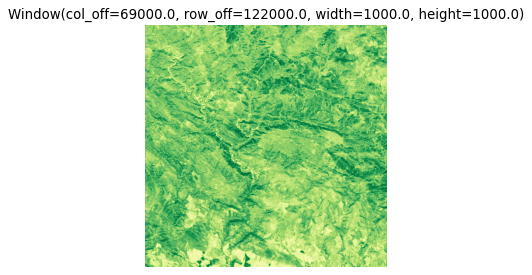

In [27]:
from eumap.parallel import TilingProcessing
from eumap.raster import read_rasters
from eumap import plotter

def plot(idx, tile, window, ndvi_summer_2000_url):
    ndvi_data, _ = read_rasters(raster_files=[ndvi_summer_2000_url], n_jobs=1, 
                                spatial_win=window, dtype="uint8")
    
    plotter.plot_rasters(ndvi_data[:,:,0], titles=[window], 
                         cmaps="RdYlGn", figsize=4, dpi=80, perc_clip=True)
    
    return ndvi_data

idx = 450 # CHange this value to visualize other parts of the mosaic
tiling= TilingProcessing()
result = tiling.process_one(idx, plot, ndvi_summer_2000_url)

You can execute the plot function in parallel using the method ``process_multiple``:

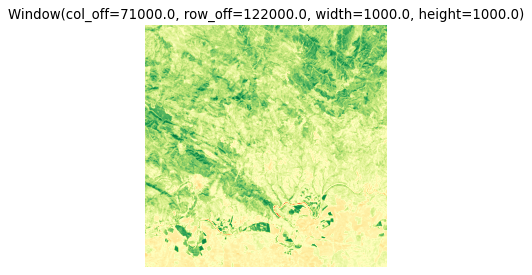

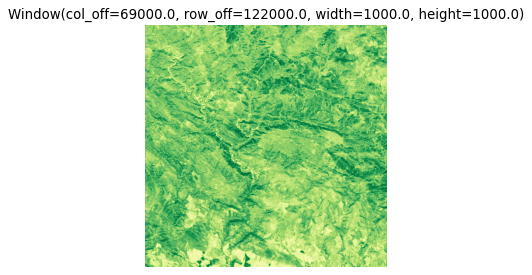

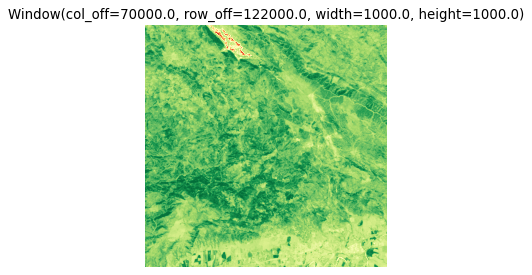

In [28]:
result = tiling.process_multiple(range(idx, idx+3), plot, ndvi_summer_2000_url)

If you have access to the red and NIR COG files (which are not available in the ODSE S3 service yet), you could perform an optimized NDVI calculation in parallel using the follow code:

In [29]:
odse_se_service = Path('https://s3.eu-central-1.wasabisys.com/eumap')

red_urls = [ odse_se_service
     .joinpath(r.name.split('_')[0])
     .joinpath(r.name) for r in raster_files
]

nir_urls = [ odse_se_service
     .joinpath(r.name.split('_')[0])
     .joinpath(r.name) for r in raster_files
]

output_dir = ODSE_DATA_DIR.joinpath('ndvi_production')

In [30]:
from eumap.parallel import TilingProcessing
from eumap.raster import read_rasters, save_rasters
from pathlib import Path

def calc_ndvi(idx, tile, window, red_urls, nir_urls, output_dir):
    #red_data, _ = read_rasters(raster_files=red_urls, spatial_win=window, dtype="float32")
    #nir_data, _ = read_rasters(raster_files=nir_urls, spatial_win=window, dtype="float32")
    
    #expression = '(nir - red) / (nir + red)'
    #params = { 'nir': nir_data, 'red': red_data }
    
    #ndvi_data = ne.evaluate(expression, params)
    
    ndvi_files = [ 
        output_dir.joinpath(r.stem.replace('_red_','_ndvi_'))
                  .joinpath(f'{idx}.tif') 
                    for r in red_urls 
    ]
    
    #save_rasters(red_urls[0], ndvi_files, ndvi_nb, dtype='float32', verbose=True)
    
    return ndvi_files

idx = 450
tiling= TilingProcessing()

ndvi_files = tiling.process_multiple(range(idx, idx+1), calc_ndvi, red_urls, nir_urls, output_dir)
print(f'Example of a file output: {ndvi_files[0][0]}')

Example of a file output: /home/opengeohub/ODSE_workdir/data/ndvi_production/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_1999.12.02..2000.03.20_eumap_epsg3035_v1.1/450.tif


And the end, this processing would produce hundreds of thousands files in the ``output_dir``.

In [31]:
print(f'Expected number of files: {tiling.num_tiles * len(ndvi_files[0])}')

Expected number of files: 591528


All these files could be aggregated in ``84`` [COG](https://gdal.org/drivers/raster/cog.html) mosaics through the [gdalbuildvrt](https://gdal.org/programs/gdalbuildvrt.html#gdalbuildvrt) and [gdal_translate](https://gdal.org/programs/gdal_translate.html) commands: